In [2]:
!pip install "torch==1.4" "torchvision==0.5.0"

     |████████████████████████████████| 753.4MB 23kB/s 
     |████████████████████████████████| 4.0MB 40.2MB/s 
  Found existing installation: torch 1.5.0+cu101
    Uninstalling torch-1.5.0+cu101:
      Successfully uninstalled torch-1.5.0+cu101
  Found existing installation: torchvision 0.6.0+cu101
    Uninstalling torchvision-0.6.0+cu101:
      Successfully uninstalled torchvision-0.6.0+cu101


In [0]:
from fastai import *
import torch
from torch import nn
import imageio
from fastai.vision import *
import os
import torch.nn.functional as F
import numpy as np

In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount = False)
%cd "/content/drive/My Drive/automatic-asset-classification"
#%cp "/content/drive/My Drive/automatic-asset-classification/data/final_dataset" .
%ls

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/automatic-asset-classification
ae_res_1_new    ae_res_3_torch  ae_res_5_torch       final_model  test.png
ae_res_1_torch  ae_res_4_new    ae_res_6_new         model1.pt
ae_res_2_new    ae_res_4-new    ae_res_6_torch       model2.pt
ae_res_2_torch  ae_res_4_torch  basic_animation.mp4  models/
ae_res_3_new    ae_res_5_new    data/                outputs/


In [5]:
np.random.seed(3333)
torch.manual_seed(3333)
image_path = "data/final_dataset"
size = 224
batchsize = 32

tfms = get_transforms(do_flip = True)
src = (ImageImageList.from_folder(image_path).split_by_rand_pct().label_from_func(lambda x: x))
data = (src.transform(tfms, size=size, tfm_y=True)
        .databunch(bs=batchsize)
        .normalize(imagenet_stats, do_y = False))
print("imported")

imported


In [0]:
data

ImageDataBunch;

Train: LabelList (444 items)
x: ImageImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
Path: data/final_dataset;

Valid: LabelList (110 items)
x: ImageImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
Path: data/final_dataset;

Test: None

In [0]:
from fastai.callbacks import *
from fastai.utils.mem import *
from torchvision.models import vgg16_bn
import torch
import torch.nn.functional as F
from fastai.torch_core import requires_grad, children

def gram_matrix(x):
    n,c,h,w = x.size()
    x = x.view(n, c, -1)
    return (x @ x.transpose(1,2))/(c*h*w)


class FeatureLoss(nn.Module):
    def __init__(self, m_feat, layer_ids, layer_wgts, base_loss):
        super().__init__()
        self.m_feat = m_feat
        self.base_loss = base_loss
        self.loss_features = [self.m_feat[i] for i in layer_ids]
        self.hooks = hook_outputs(self.loss_features, detach=False)
        self.wgts = layer_wgts
        self.metric_names = ['pixel',] + [f'feat_{i}' for i in range(len(layer_ids))
              ] + [f'gram_{i}' for i in range(len(layer_ids))]

    def make_features(self, x, clone=False):
        self.m_feat(x)
        return [(o.clone() if clone else o) for o in self.hooks.stored]

    def forward(self, input, target):
        out_feat = self.make_features(target, clone=True)
        in_feat = self.make_features(input)
        self.feat_losses = [self.base_loss(input,target)]
        self.feat_losses += [self.base_loss(f_in, f_out)*w
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.feat_losses += [self.base_loss(gram_matrix(f_in), gram_matrix(f_out))*w**2 * 5e3
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.metrics = dict(zip(self.metric_names, self.feat_losses))
        return sum(self.feat_losses)

    def __del__(self): self.hooks.remove()

In [0]:
import torch
from torch import nn
from fastai.torch_core import *
from fastai.core import ifnone
from fastai.layers import *

class reshape(nn.Module):
    '''a torch layer to reshape the input into size = shape = type list'''
    def __init__(self, shape):
        super(reshape, self).__init__()
        self.shape = shape
    def forward(self, x): return x.reshape(self.shape)

class convblock(nn.Module):
    '''
    a convolutional block used in the model:
    conv(in, out) -> batchnorm(out) -> relu
    '''
    def __init__(self, in_:int, out:int):
      super().__init__()
      self.conv1 = nn.Conv2d(in_, out, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      self.bn = nn.BatchNorm2d(out, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
      x = self.conv1(x)
      x = self.bn(x)
      x = self.relu(x)
      return x

class downsamp(nn.Module):
    ''' a downsampling block. using adaptive max pooling so select the size to be outputted and the scale you would like output ie out (3,10,10) is a downsamp(3, 10).
    '''
    def __init__(self, size:int, scale:int=2):
      super().__init__()
      self.pool = nn.AdaptiveMaxPool2d(scale)
      self.bn = nn.BatchNorm2d(size, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      self.relu = nn.ReLU(inplace = True)

    def forward(self,x):
      x = self.pool(x)
      x = self.bn(x)
      x = self.relu(x)
      return x

class Upsample(nn.Module):
    '''
    upsample by scale = scale. Ins and outs are input. Upsampling method is nearest neighbour.
    '''
    def __init__(self, in_:int, out:int, scale:int=2):
      super().__init__()
      self.upsample = nn.Upsample(scale_factor=scale, mode='nearest')
      self.bn = nn.BatchNorm2d(in_, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      self.conv1 = nn.Sequential(
              nn.Conv2d(in_, out, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
              nn.BatchNorm2d(out, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
              nn.ReLU(inplace=True)
              )

    def forward(self, x):
      x = self.upsample(x)
      x = self.bn(x)
      x = self.conv1(x)
      return x

In [0]:
class encoder(nn.Module):
    def __init__(self):
        super(encoder, self).__init__()
        self.convblock1 = convblock(3,12)
        self.convblock2 = convblock(12,12)
        self.downsamp1 = downsamp(12, 112)
        self.convblock3 = convblock(12, 24)
        self.downsamp2 = downsamp(24, 16)

        self.bottleneck = nn.Sequential(nn.Flatten(), 
                                        nn.Linear(24 * 16 * 16, 1568),
                                        nn.Linear(1568,1024))

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.downsamp1(x)

        x = self.convblock3(x)
        x = self.downsamp2(x)

        x = self.bottleneck(x)

        return x

class decoder(nn.Module):
    def __init__(self):
        super(decoder, self).__init__()

        self.bottleneck = nn.Sequential(nn.Linear(1024, 1568),
                                        nn.Linear(1568, 24*16*16),
                                        reshape([-1,24,16,16])
                                        )

        self.up1 = Upsample(24,12,7)
        self.convblock1= convblock(12,12)
        self.up3 = Upsample(12,3)

    def forward(self,x):
        x = self.bottleneck(x)
        x = self.up1(x)
        x = self.convblock1(x)
        x = self.up3(x)
        return x

class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()

        self.encoder = encoder()
        self.decoder = decoder()

    def encode(self, x): return self.encoder(x)
    def decode(self, x): return torch.clamp(self.decoder(x), min = 0, max = 1)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return torch.clamp(x, min = 0, max = 1)


In [0]:
AE=autoencoder()

In [0]:
vgg_m = vgg16_bn(True).features.cuda().eval()

requires_grad(vgg_m, False)
blocks = [i-1 for i,o in enumerate(children(vgg_m)) if isinstance(o,nn.MaxPool2d)]

base_loss = F.mse_loss

feat_loss = FeatureLoss(vgg_m, blocks[0:3], [30,20,10], base_loss)

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/checkpoints/vgg16_bn-6c64b313.pth


In [0]:
learn = Learner(data,AE,loss_func=feat_loss,metrics=[mean_squared_error, mean_absolute_error])

In [0]:
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,mean_squared_error,mean_absolute_error,time
0,1.249300,0.739083,0.271904,0.464103,01:31
1,0.985148,0.738766,0.259357,0.451371,00:26
2,0.854395,0.660606,0.169766,0.339891,00:24
3,0.774194,0.608821,0.131901,0.287963,00:24
4,0.723370,0.590873,0.121099,0.273630,00:23


In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.20E-01
Min loss divided by 10: 1.74E-02


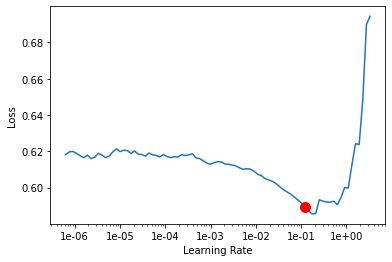

In [0]:
learn.recorder.plot(suggestion=True)

In [0]:
learn.fit_one_cycle(10, max_lr = 1e-02)

epoch,train_loss,valid_loss,mean_squared_error,mean_absolute_error,time
0,0.610398,0.564327,0.105842,0.254868,00:22
1,0.592825,0.575060,0.112140,0.268024,00:23
2,0.568935,0.600066,0.120751,0.275199,00:23
3,0.553141,0.484172,0.065467,0.210515,00:23
4,0.540500,0.510773,0.072102,0.215396,00:23
5,0.530798,0.470098,0.058342,0.200554,00:23
6,0.521766,0.479898,0.063413,0.206977,00:23
7,0.515381,0.478907,0.064076,0.207481,00:23
8,0.509291,0.474261,0.063510,0.206134,00:23
9,0.504458,0.474258,0.063831,0.206366,00:23


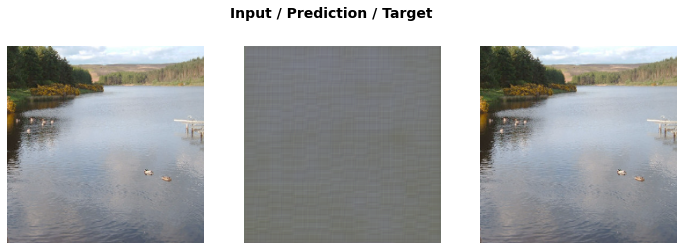

In [0]:
learn.show_results(ds_type=DatasetType.Train, rows=1)

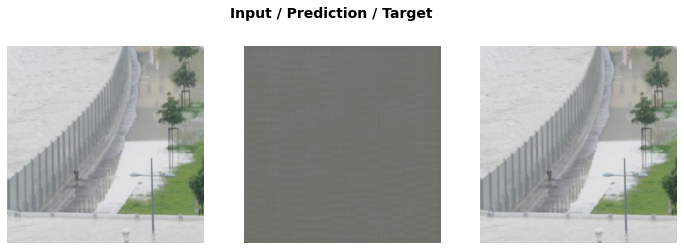

In [0]:
learn.show_results(ds_type=DatasetType.Valid,rows=1)

In [0]:
class Autoencoder2(nn.Module):

    def __init__(self):
        super(Autoencoder2, self).__init__()
        
        self.convblock1 = convblock(3,12)
        self.convblock2 = convblock(12,12)
        self.downsamp1 = downsamp(12, 112)


        self.encoder = nn.Sequential(
            nn.Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size = (2,2), stride = (2,2)),
            nn.BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.AdaptiveMaxPool2d(16),
            nn.BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Flatten(),
            nn.Linear(24 * 16 * 16, 1568),
            nn.Linear(1568, 1024)
        )

        self.decoder = nn.Sequential(
            nn.Linear(1024, 1568),
            nn.Linear(1568, 24 * 16 * 16),
            reshape([-1,24,16,16]),
            nn.Conv2d(24, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            PixelShuffle_ICNR(12, 12, scale=7),
            nn.BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            PixelShuffle_ICNR(12, 3),
            nn.BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
        )
        
    def encode(self,x): return self.encoder(x)
    
    def decode(self,x): return torch.clamp(self.decoder(x), min = 0, max=1)
        

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return torch.clamp(decoded, min=0, max=1)

In [0]:
ae2 = Autoencoder2()
learn2 = Learner(data, ae2, loss_func = F.mse_loss)

In [0]:
learn2.fit_one_cycle(5)

epoch,train_loss,valid_loss,time
0,0.254107,0.245377,00:22
1,0.240359,0.217608,00:21
2,0.229178,0.196285,00:21
3,0.217968,0.186721,00:21
4,0.209734,0.186338,00:21


In [0]:
learn2.lr_find()

epoch,train_loss,valid_loss,time
0,0.190214,#na#,00:17
1,0.189308,#na#,00:15
2,0.189111,#na#,00:16
3,0.189733,#na#,00:15
4,0.187190,#na#,00:16
5,0.168194,#na#,00:15
6,0.168733,#na#,00:15


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 5.75E-02
Min loss divided by 10: 5.25E-02


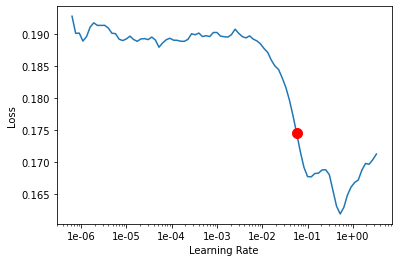

In [0]:
learn2.recorder.plot(suggestion=True)

In [0]:
learn2.fit_one_cycle(10, max_lr=1e-02)

epoch,train_loss,valid_loss,time
0,0.185977,0.176591,00:21
1,0.175457,0.188192,00:22
2,0.146708,0.068057,00:21
3,0.112545,0.062135,00:21
4,0.090920,0.039983,00:21
5,0.076032,0.035699,00:21
6,0.065506,0.035070,00:21
7,0.057706,0.033419,00:21
8,0.052093,0.033211,00:21
9,0.047951,0.033024,00:20


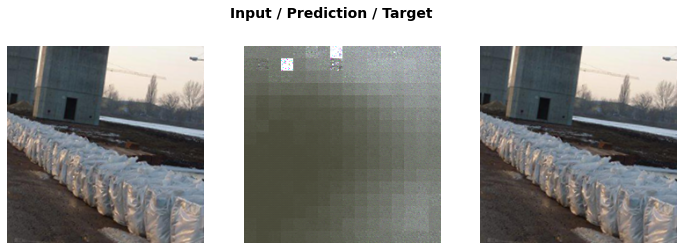

In [0]:
learn2.show_results(ds_type=DatasetType.Train,rows=1)

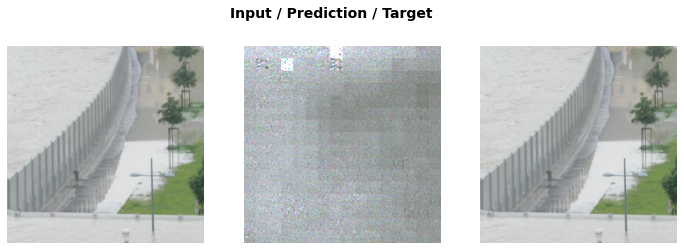

In [0]:
learn2.show_results(ds_type=DatasetType.Valid,rows=1)

In [0]:
torch.save(learn.model, "model1.pt")
torch.save(learn2.model, "model2.pt")

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type autoencoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type encoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type convblock. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type downsamp. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python

In [0]:
%cp "/content/drive/My Drive/automatic-asset-classification/models/model1.pt" "model1.pt"
%cp "/content/drive/My Drive/automatic-asset-classification/models/model2.pt" "model2.pt"

In [0]:
class Encoder1(nn.Module):
    def __init__(self):
        super(Encoder1, self).__init__()
        self.encoder = torch.load("model1.pt").encoder
        
    def encode(self,x): return self.encoder(x)
    
    def decode(self,x): return torch.clamp(self.decoder(x), min = 0, max=1)
        
    def forward(self, x):
        encoded = self.encoder(x)
        return encoded

class Encoder2(nn.Module):

    def __init__(self):
        super(Encoder2, self).__init__()  
        self.encoder = torch.load("model2.pt").encoder
        
    def encode(self,x): return self.encoder(x)        

    def forward(self, x):
        encoded = self.encoder(x)
        return encoded

In [0]:
ec1,ec2 = Encoder1(), Encoder2()
enc1=Learner(data, ec1,loss_func=F.mse_loss)
enc2=Learner(data, ec2,loss_func=F.mse_loss)

In [15]:
preds_1,acts_1=enc1.get_preds()

In [16]:
acts_1.shape, preds_1.shape

(torch.Size([110, 3, 224, 224]), torch.Size([110, 1024]))

In [17]:
preds_2,acts_2=enc2.get_preds()

In [0]:
cluster_data_1 = preds_1.numpy()

In [0]:
cluster_data_std_1 = (cluster_data_1 - cluster_data_1.mean())/cluster_data_1.std()

In [0]:
cluster_data_2 = preds_2.numpy()

In [0]:
cluster_data_std_2 = (cluster_data_2 - cluster_data_2.mean())/cluster_data_2.std()

In [0]:
from sklearn.decomposition import PCA
pca = PCA(n_components=50)
cluster_data_pca_1 = pca.fit_transform(cluster_data_std_1)

In [0]:
pca = PCA(n_components=50)
cluster_data_pca_2 = pca.fit_transform(cluster_data_std_2)

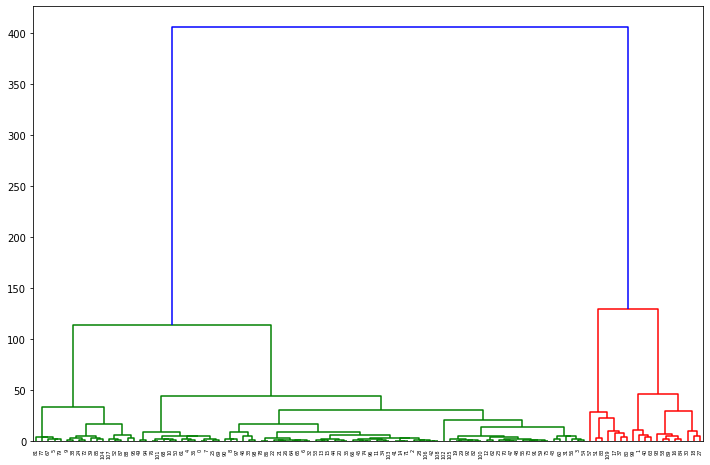

In [24]:
from scipy.cluster.hierarchy import dendrogram, linkage
linked = linkage(cluster_data_pca_1, method = 'ward')
fig = plt.figure(figsize = (12,8))
dendrogram(linked,
            orientation='top',
            #labels=labelList,
            distance_sort='descending',
            show_leaf_counts=True)
plt.show()

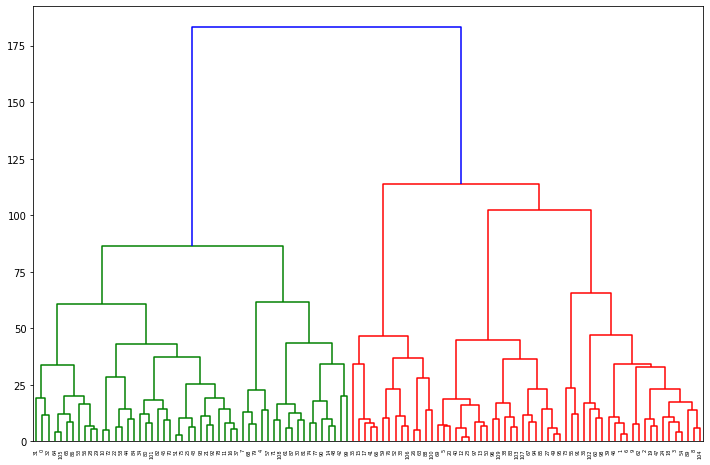

In [25]:
linked = linkage(cluster_data_pca_2, method = 'ward')
fig = plt.figure(figsize = (12,8))
dendrogram(linked,
            orientation='top',
            #labels=labelList,
            distance_sort='descending',
            show_leaf_counts=True)
plt.show()

In [0]:
from sklearn.manifold import TSNE
X1_embedded = TSNE(n_components=2, perplexity = 5).fit_transform(cluster_data_pca_1)
X1_embedded2 = TSNE(n_components=2, perplexity = 30).fit_transform(cluster_data_pca_1)
X1_embedded3 = TSNE(n_components=2, perplexity = 50).fit_transform(cluster_data_pca_1)

X2_embedded = TSNE(n_components=2, perplexity = 5).fit_transform(cluster_data_pca_2)
X2_embedded2 = TSNE(n_components=2, perplexity = 30).fit_transform(cluster_data_pca_2)
X2_embedded3 = TSNE(n_components=2, perplexity = 50).fit_transform(cluster_data_pca_2)

In [0]:
from sklearn.cluster import AgglomerativeClustering
cluster = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')
clusters_1 = cluster.fit_predict(cluster_data_pca_1)

In [0]:
cluster2 = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')
clusters_2 = cluster2.fit_predict(cluster_data_pca_2)

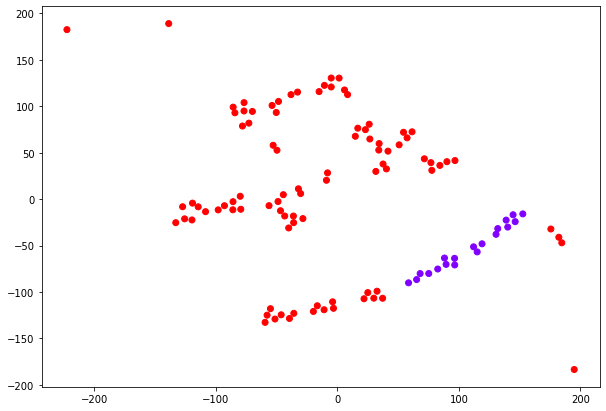

In [44]:
plt.figure(figsize=(10, 7))
plt.scatter(X1_embedded[:,0], X1_embedded[:,1], c=cluster.labels_, cmap='rainbow')

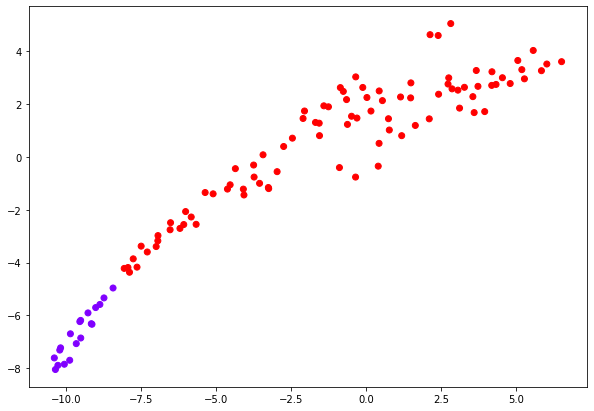

In [45]:
plt.figure(figsize=(10, 7))
plt.scatter(X1_embedded2[:,0], X1_embedded2[:,1], c=cluster.labels_, cmap='rainbow')

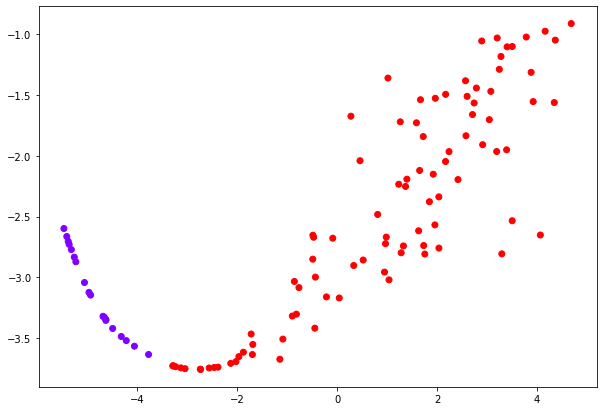

In [46]:
plt.figure(figsize=(10, 7))
plt.scatter(X1_embedded3[:,0], X1_embedded3[:,1], c=cluster.labels_, cmap='rainbow')

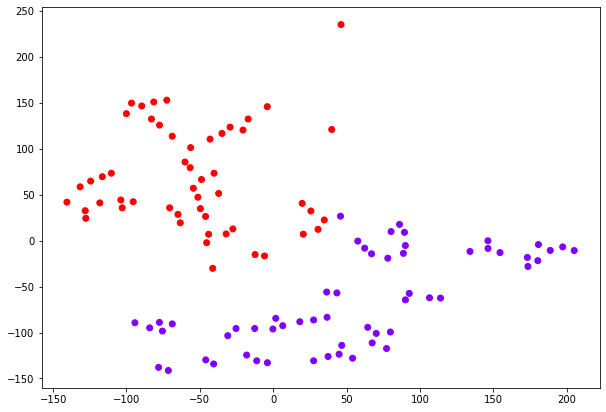

In [47]:
plt.figure(figsize=(10, 7))
plt.scatter(X2_embedded[:,0], X2_embedded[:,1], c=cluster2.labels_, cmap='rainbow')

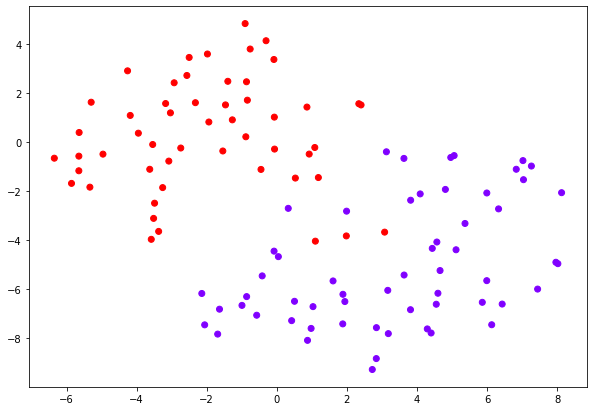

In [48]:
plt.figure(figsize=(10, 7))
plt.scatter(X2_embedded2[:,0], X2_embedded2[:,1], c=cluster2.labels_, cmap='rainbow')

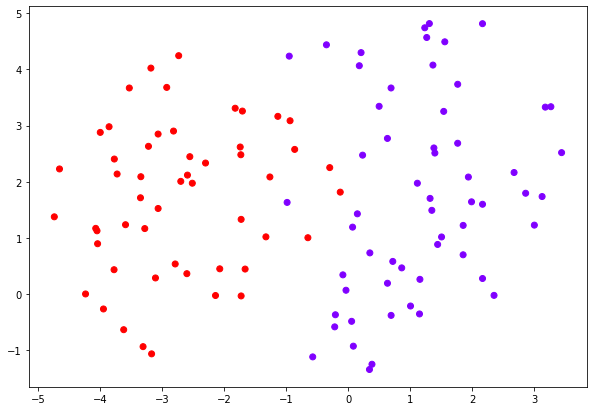

In [49]:
plt.figure(figsize=(10, 7))
plt.scatter(X2_embedded3[:,0], X2_embedded3[:,1], c=cluster2.labels_, cmap='rainbow')

In [0]:
one_idx = []
two_idx = []

for i in range(len(clusters_2)):
  if clusters_2[i] == 0:
    one_idx.append(i)
  if clusters_2[i] == 1:
    two_idx.append(i)

In [0]:
for idx in one_idx:
  data.valid_ds[idx][0].save("/content/drive/My Drive/automatic-asset-classification/outputs/basic_autoencoder/class1/"+str(idx)+".png")
for idx in two_idx:
  data.valid_ds[idx][0].save("/content/drive/My Drive/automatic-asset-classification/outputs/basic_autoencoder/class2/"+str(idx)+".png")

In [0]:
plt.figure(figsize=(10, 7))
plt.scatter(X2_embedded[:,0], X2_embedded[:,1], c=cluster2.labels_, cmap='rainbow')

In [0]:
%cp "model1.pt" "/content/drive/My Drive/automatic-asset-classification/models/model1.pt" 
%cp "model2.pt" "/content/drive/My Drive/automatic-asset-classification/models/model2.pt"